<a href="https://colab.research.google.com/github/emanuel379/Series-Temporais-e-Aprendizado-Dinamico/blob/main/M%C3%B3dulo_4_Estat%C3%ADstica_Bayesiana_An%C3%A1lise_de_s%C3%A9ries_temporais_University_of_California%2C_Santa_Cruz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
install.packages("gtrendsR")
install.packages("dlm")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘BH’, ‘anytime’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



O código R abaixo ajusta um Modelo Linear Dinâmico Normal à série temporal mensal de "hits" das tendências do Google para o termo "série temporal". O modelo tem dois componentes: (a) um modelo polinomial de ordem 2 e (b) um componente sazonal com 4 frequências: 𝜔1 = 2𝜋/12 (ciclo anual), 𝜔2 = 2𝜋/6 (ciclo de 6 meses), 𝜔3 = 2𝜋/4 e 𝜔4 = 2𝜋/3. O modelo pressupõe que a variância observacional 𝑣 é desconhecida e a matriz de variância-covariância do sistema 𝑊𝑡 é especificada usando um único fator de desconto. O fator de desconto é escolhido usando um critério de otimização, conforme explicado no curso.

O senhor será solicitado a modificar o código para considerar um DLM com dois componentes: (a) um modelo polinomial de ordem 1 e (b) um componente sazonal que contém um período fundamental de 𝑝 = 12 e 2 harmônicos adicionais para um total de 3 frequências: 𝜔1 = 2𝜋/12, 𝜔2 = 2𝜋/6 e 𝜔3 = 2𝜋/4. O senhor também precisará otimizar a escolha do fator de desconto para esse modelo.  O senhor será solicitado a carregar imagens que resumam seus resultados.

In [15]:
# download data
library(gtrendsR)
timeseries_data<-gtrends("time series",time="all")
plot(timeseries_data)
names(timeseries_data)

timeseries_data=timeseries_data$interest_over_time
data=list(yt=timeseries_data$hits)

library(dlm)
model_seasonal=dlmModTrig(s=12,q=4,dV=0,dW=1)
model_trend=dlmModPoly(order=2,dV=10,dW=rep(1,2),m0=c(40,0))
model=model_trend+model_seasonal
model$C0=10*diag(10)
n0=1
S0=10
k=length(model$m0)
T=length(data$yt)

Ft=array(0,c(1,k,T))
Gt=array(0,c(k,k,T))
for(t in 1:T){
   Ft[,,t]=model$FF
   Gt[,,t]=model$GG
}

source('all_dlm_functions_unknown_v.R')
source('discountfactor_selection_functions.R')

matrices=set_up_dlm_matrices_unknown_v(Ft=Ft,Gt=Gt)
initial_states=set_up_initial_states_unknown_v(model$m0,
                                               model$C0,n0,S0)

df_range=seq(0.9,1,by=0.005)

## fit discount DLM
## MSE
results_MSE <- adaptive_dlm(data, matrices,
               initial_states, df_range,"MSE",forecast=FALSE)

## print selected discount factor
print(paste("The selected discount factor:",results_MSE$df_opt))

## retrieve filtered results
results_filtered <- results_MSE$results_filtered
ci_filtered <- get_credible_interval_unknown_v(
  results_filtered$ft,results_filtered$Qt,results_filtered$nt)

## retrieve smoothed results
results_smoothed <- results_MSE$results_smoothed
ci_smoothed <- get_credible_interval_unknown_v(
  results_smoothed$fnt, results_smoothed$Qnt,
  results_filtered$nt[length(results_smoothed$fnt)])

## plot smoothing results
par(mfrow=c(1,1))
index <- timeseries_data$date
plot(index, data$yt, ylab='Google hits',
     main = "Google Trends: time series", type = 'l',
     xlab = 'time', lty=3,ylim=c(0,100))
lines(index, results_smoothed$fnt, type = 'l', col='blue',
      lwd=2)
lines(index, ci_smoothed[, 1], type='l', col='blue', lty=2)
lines(index, ci_smoothed[, 2], type='l', col='blue', lty=2)

# Plot trend and rate of change
par(mfrow=c(2,1))
plot(index,data$yt,pch=19,cex=0.3,col='lightgray',xlab="time",
     ylab="Google hits",main="trend")
lines(index,results_smoothed$mnt[,1],lwd=2,col='magenta')
plot(index,results_smoothed$mnt[,2],col='darkblue',lwd=2,
     type='l', ylim=c(-0.6,0.6), xlab="time",
     ylab="rate of change")
abline(h=0,col='red',lty=2)

# Plot seasonal components
par(mfrow=c(2,2))
plot(index,results_smoothed$mnt[,3],lwd=2,col="darkgreen",
     type='l', xlab="time",ylab="",main="period=12",
     ylim=c(-12,12))
plot(index,results_smoothed$mnt[,5],lwd=2,col="darkgreen",
     type='l',xlab="time",ylab="",main="period=6",
     ylim=c(-12,12))
plot(index,results_smoothed$mnt[,7],lwd=2,col="darkgreen",
     type='l', xlab="time",ylab="",main="period=4",
     ylim=c(-12,12))
plot(index,results_smoothed$mnt[,9],lwd=2,col="darkgreen",
     type='l', xlab="time",ylab="",main="period=3",
     ylim=c(-12,12))

#Estimate for the observational variance: St[T]
results_filtered$St[T]

ERROR: Error in interest_over_time(widget, comparison_item, tz): Status code was not 200. Returned status code:429


In [47]:
## create list for matrices
set_up_dlm_matrices_unknown_v <- function(Ft, Gt, Wt_star){
  if(!is.array(Gt)){
    Stop("Gt and Ft should be array")
  }
  if(missing(Wt_star)){
    return(list(Ft=Ft, Gt=Gt))
  }else{
    return(list(Ft=Ft, Gt=Gt, Wt_star=Wt_star))
  }
}


## create list for initial states
set_up_initial_states_unknown_v <- function(m0, C0_star, n0, S0){
  return(list(m0=m0, C0_star=C0_star, n0=n0, S0=S0))
}

forward_filter_unknown_v <- function(data, matrices,
                              initial_states, delta){
  ## retrieve dataset
  yt <- data$yt
  T<- length(yt)

  ## retrieve matrices
  Ft <- matrices$Ft
  Gt <- matrices$Gt
  if(missing(delta)){
    Wt_star <- matrices$Wt_star
  }

  ## retrieve initial state
  m0 <- initial_states$m0
  C0_star <- initial_states$C0_star
  n0 <- initial_states$n0
  S0 <- initial_states$S0
  C0 <- S0*C0_star

  ## create placeholder for results
  d <- dim(Gt)[1]
  at <- matrix(0, nrow=T, ncol=d)
  Rt <- array(0, dim=c(d, d, T))
  ft <- numeric(T)
  Qt <- numeric(T)
  mt <- matrix(0, nrow=T, ncol=d)
  Ct <- array(0, dim=c(d, d, T))
  et <- numeric(T)
  nt <- numeric(T)
  St <- numeric(T)
  dt <- numeric(T)

  # moments of priors at t
  for(i in 1:T){
    if(i == 1){
      at[i, ] <- Gt[, , i] %*% m0
      Pt <- Gt[, , i] %*% C0 %*% t(Gt[, , i])
      Pt <- 0.5*Pt + 0.5*t(Pt)
      if(missing(delta)){
        Wt <- Wt_star[, , i]*S0
        Rt[, , i] <- Pt + Wt
        Rt[,,i] <- 0.5*Rt[,,i]+0.5*t(Rt[,,i])
      }else{
        Rt[, , i] <- Pt/delta
        Rt[,,i] <- 0.5*Rt[,,i]+0.5*t(Rt[,,i])
      }

    }else{
      at[i, ] <- Gt[, , i] %*% t(mt[i-1, , drop=FALSE])
      Pt <- Gt[, , i] %*% Ct[, , i-1] %*% t(Gt[, , i])
      if(missing(delta)){
        Wt <- Wt_star[, , i] * St[i-1]
        Rt[, , i] <- Pt + Wt
        Rt[,,i]=0.5*Rt[,,i]+0.5*t(Rt[,,i])
      }else{
        Rt[, , i] <- Pt/delta
        Rt[,,i] <- 0.5*Rt[,,i]+0.5*t(Rt[,,i])
      }
    }

    # moments of one-step forecast:
    ft[i] <- t(Ft[, , i]) %*% t(at[i, , drop=FALSE])
    Qt[i] <- t(Ft[, , i]) %*% Rt[, , i] %*% Ft[, , i] +
      ifelse(i==1, S0, St[i-1])
    et[i] <- yt[i] - ft[i]

    nt[i] <- ifelse(i==1, n0, nt[i-1]) + 1
    St[i] <- ifelse(i==1, S0,
                    St[i-1])*(1 + 1/nt[i]*(et[i]^2/Qt[i]-1))

    # moments of posterior at t:
    At <- Rt[, , i] %*% Ft[, , i] / Qt[i]

    mt[i, ] <- at[i, ] + t(At) * et[i]
    Ct[, , i] <- St[i]/ifelse(i==1, S0,
                  St[i-1])*(Rt[, , i] - Qt[i] * At %*% t(At))
    Ct[,,i] <- 0.5*Ct[,,i]+0.5*t(Ct[,,i])
  }
  cat("Forward filtering is completed!\n")
  return(list(mt = mt, Ct = Ct,  at = at, Rt = Rt,
              ft = ft, Qt = Qt,  et = et,
              nt = nt, St = St))
}

### smoothing function ###
backward_smoothing_unknown_v <- function(data, matrices,
                                posterior_states,delta){
  ## retrieve data
  yt <- data$yt
  T <- length(yt)

  ## retrieve matrices
  Ft <- matrices$Ft
  Gt <- matrices$Gt

  ## retrieve matrices
  mt <- posterior_states$mt
  Ct <- posterior_states$Ct
  Rt <- posterior_states$Rt
  nt <- posterior_states$nt
  St <- posterior_states$St
  at <- posterior_states$at

  ## create placeholder for posterior moments
  mnt <- matrix(NA, nrow = dim(mt)[1], ncol = dim(mt)[2])
  Cnt <- array(NA, dim = dim(Ct))
  fnt <- numeric(T)
  Qnt <- numeric(T)

  for(i in T:1){
    if(i == T){
      mnt[i, ] <- mt[i, ]
      Cnt[, , i] <- Ct[, , i]
    }else{
      if(missing(delta)){
        inv_Rtp1 <- chol2inv(chol(Rt[, , i+1]))
        Bt <- Ct[, , i] %*% t(Gt[, , i+1]) %*% inv_Rtp1
        mnt[i, ] <- mt[i, ] + Bt %*% (mnt[i+1, ] - at[i+1, ])
        Cnt[, , i] <- Ct[, , i] + Bt %*% (Cnt[, , i+1] -
                                    Rt[, , i+1]) %*% t(Bt)
        Cnt[,,i] <- 0.5*Cnt[,,i]+0.5*t(Cnt[,,i])
      }else{
        inv_Gt <- solve(Gt[, , i+1])
        mnt[i, ] <- (1-delta)*mt[i, ] +
                delta*inv_Gt %*% t(mnt[i+1, ,drop=FALSE])
        Cnt[, , i] <- (1-delta)*Ct[, , i] +
                delta^2*inv_Gt %*% Cnt[, , i + 1]  %*% t(inv_Gt)
        Cnt[,,i] <- 0.5*Cnt[,,i]+0.5*t(Cnt[,,i])
      }
    }
    fnt[i] <- t(Ft[, , i]) %*% t(mnt[i, , drop=FALSE])
    Qnt[i] <- t(Ft[, , i]) %*% t(Cnt[, , i]) %*% Ft[, , i]
  }
  for(i in 1:T){
     Cnt[,,i]=St[T]*Cnt[,,i]/St[i]
     Qnt[i]=St[T]*Qnt[i]/St[i]
  }
  cat("Backward smoothing is completed!\n")
  return(list(mnt = mnt, Cnt = Cnt, fnt=fnt, Qnt=Qnt))
}

## Forecast Distribution for k step
forecast_function_unknown_v <- function(posterior_states, k,
                                        matrices, delta){

  ## retrieve matrices
  Ft <- matrices$Ft
  Gt <- matrices$Gt
  if(missing(delta)){
    Wt_star <- matrices$Wt_star
  }

  mt <- posterior_states$mt
  Ct <- posterior_states$Ct
  St <- posterior_states$St
  at <- posterior_states$at

  ## set up matrices
  T <- dim(mt)[1] # time points
  d <- dim(mt)[2] # dimension of state parameter vector

  ## placeholder for results
  at <- matrix(NA, nrow = k, ncol = d)
  Rt <- array(NA, dim=c(d, d, k))
  ft <- numeric(k)
  Qt <- numeric(k)

  for(i in 1:k){
    ## moments of state distribution
    if(i == 1){
      at[i, ] <- Gt[, , T+i] %*% t(mt[T, , drop=FALSE])

      if(missing(delta)){
       Rt[, , i] <- Gt[, , T+i] %*% Ct[, , T] %*%
         t(Gt[, , T+i]) + St[T]*Wt_star[, , T+i]
      }else{
        Rt[, , i] <- Gt[, , T+i] %*% Ct[, , T] %*%
          t(Gt[, , T+i])/delta
      }
      Rt[,,i] <- 0.5*Rt[,,i]+0.5*t(Rt[,,i])

    }else{
      at[i, ] <- Gt[, , T+i] %*% t(at[i-1, , drop=FALSE])
      if(missing(delta)){
        Rt[, , i] <- Gt[, , T+i] %*% Rt[, , i-1] %*%
          t(Gt[, , T+i]) + St[T]*Wt_star[, , T + i]
      }else{
        Rt[, , i] <- Gt[, , T+i] %*% Rt[, , i-1] %*%
          t(Gt[, , T+i])/delta
      }
      Rt[,,i] <- 0.5*Rt[,,i]+0.5*t(Rt[,,i])
    }


    ## moments of forecast distribution
    ft[i] <- t(Ft[, , T+i]) %*% t(at[i, , drop=FALSE])
    Qt[i] <- t(Ft[, , T+i]) %*% Rt[, , i] %*% Ft[, , T+i] +
      St[T]
  }
  cat("Forecasting is completed!\n") # indicator of completion
  return(list(at=at, Rt=Rt, ft=ft, Qt=Qt))
}

## obtain 95% credible interval
get_credible_interval_unknown_v <- function(ft, Qt, nt,
                                   quantile = c(0.025, 0.975)){
  bound <- matrix(0, nrow=length(ft), ncol=2)

  if ((length(nt)==1)){
   for (t in 1:length(ft)){
      t_quantile <- qt(quantile[1], df = nt)
      bound[t, 1] <- ft[t] + t_quantile*sqrt(as.numeric(Qt[t]))

  # upper bound of 95% credible interval
      t_quantile <- qt(quantile[2], df = nt)
      bound[t, 2] <- ft[t] +
        t_quantile*sqrt(as.numeric(Qt[t]))}
  }else{
  # lower bound of 95% credible interval
    for (t in 1:length(ft)){
      t_quantile <- qt(quantile[1], df = nt[t])
      bound[t, 1] <- ft[t] +
        t_quantile*sqrt(as.numeric(Qt[t]))

  # upper bound of 95% credible interval
      t_quantile <- qt(quantile[2], df = nt[t])
      bound[t, 2] <- ft[t] +
        t_quantile*sqrt(as.numeric(Qt[t]))}
  }
  return(bound)

}

In [48]:
##################################################
##### using discount factor ##########
##################################################
## compute measures of forecasting accuracy
## MAD: mean absolute deviation
## MSE: mean square error
## MAPE: mean absolute percentage error
## Neg LL: Negative log-likelihood of disc,
##         based on the one step ahead forecast distribution
measure_forecast_accuracy <- function(et, yt, Qt=NA, nt=NA, type){
  if(type == "MAD"){
    measure <- mean(abs(et))
  }else if(type == "MSE"){
    measure <- mean(et^2)
  }else if(type == "MAPE"){
    measure <- mean(abs(et)/yt)
  }else if(type == "NLL"){
    measure <- log_likelihood_one_step_ahead(et, Qt, nt)
  }else{
    stop("Wrong type!")
  }
  return(measure)
}


## compute log likelihood of one step ahead forecast function
log_likelihood_one_step_ahead <- function(et, Qt, nt){
  ## et:the one-step-ahead error
  ## Qt: variance of one-step-ahead forecast function
  ## nt: degrees freedom of t distribution
  T <- length(et)
  aux=0
  for (t in 1:T){
    zt=et[t]/sqrt(Qt[t])
    aux=(dt(zt,df=nt[t],log=TRUE)-log(sqrt(Qt[t]))) + aux
  }
  return(-aux)
}

## Maximize log density of one-step-ahead forecast function to select discount factor
adaptive_dlm <- function(data, matrices, initial_states, df_range, type,
                         forecast=TRUE){
  measure_best <- NA
  measure <- numeric(length(df_range))
  valid_data <- data$valid_data
  df_opt <- NA
  j <- 0
  ## find the optimal discount factor
  for(i in df_range){
    j <- j + 1
    results_tmp <- forward_filter_unknown_v(data, matrices, initial_states, i)

    measure[j] <- measure_forecast_accuracy(et=results_tmp$et, yt=data$yt,
                                  Qt=results_tmp$Qt,
                                  nt=c(initial_states$n0,results_tmp$nt), type=type)


    if(j == 1){
      measure_best <- measure[j]
      results_filtered <- results_tmp
      df_opt <- i
    }else if(measure[j] < measure_best){
      measure_best <- measure[j]
      results_filtered <- results_tmp
      df_opt <- i
    }
  }
  results_smoothed <- backward_smoothing_unknown_v(data, matrices, results_filtered, delta = df_opt)
  if(forecast){
    results_forecast <- forecast_function(results_filtered, length(valid_data),
                                          matrices, df_opt)
    return(list(results_filtered=results_filtered,
                results_smoothed=results_smoothed,
                results_forecast=results_forecast,
                df_opt = df_opt, measure=measure))
  }else{
    return(list(results_filtered=results_filtered,
                results_smoothed=results_smoothed,
                df_opt = df_opt, measure=measure))
  }

}

Código do exercício

[1] "interest_over_time"  "interest_by_country" "interest_by_region" 
[4] "interest_by_dma"     "interest_by_city"    "related_topics"     
[7] "related_queries"

Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Backward smoothing is completed!
[1] "The selected discount factor: 0.9"


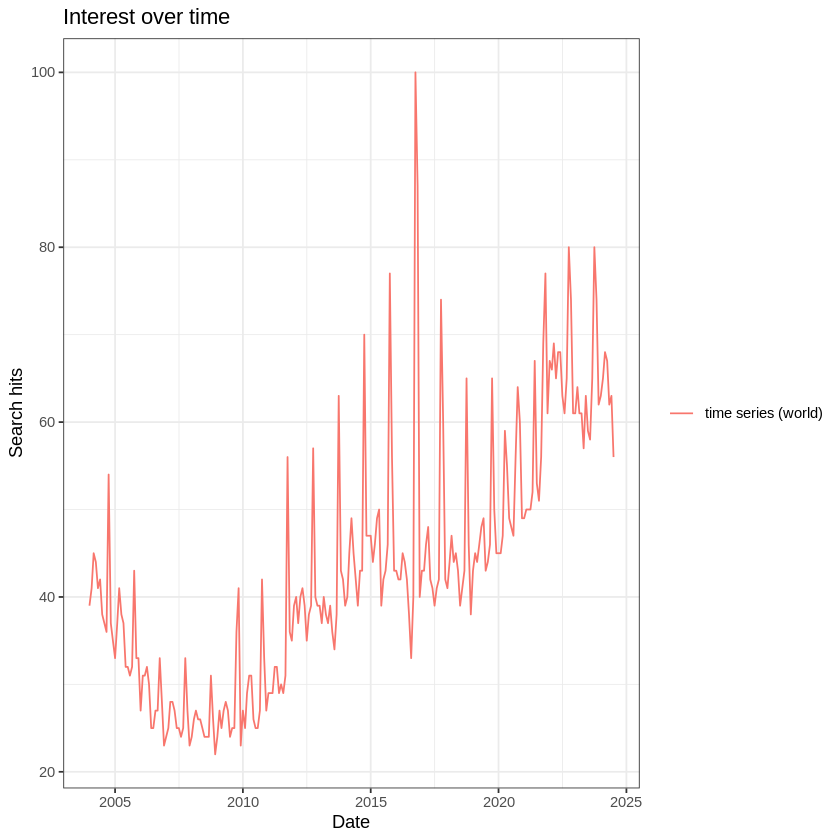

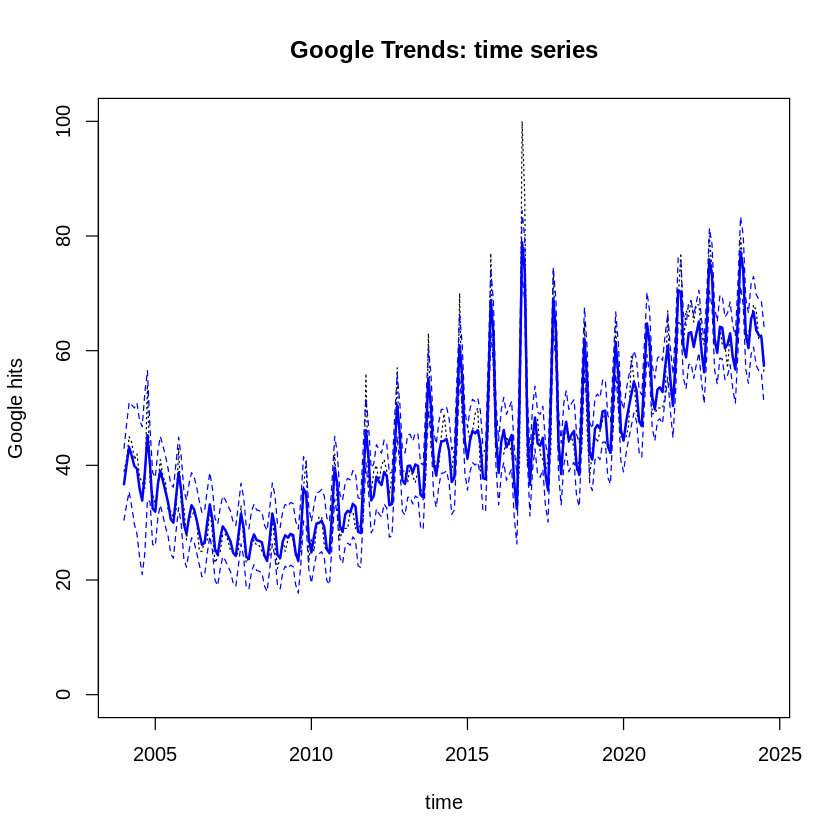

[1] 22.67273

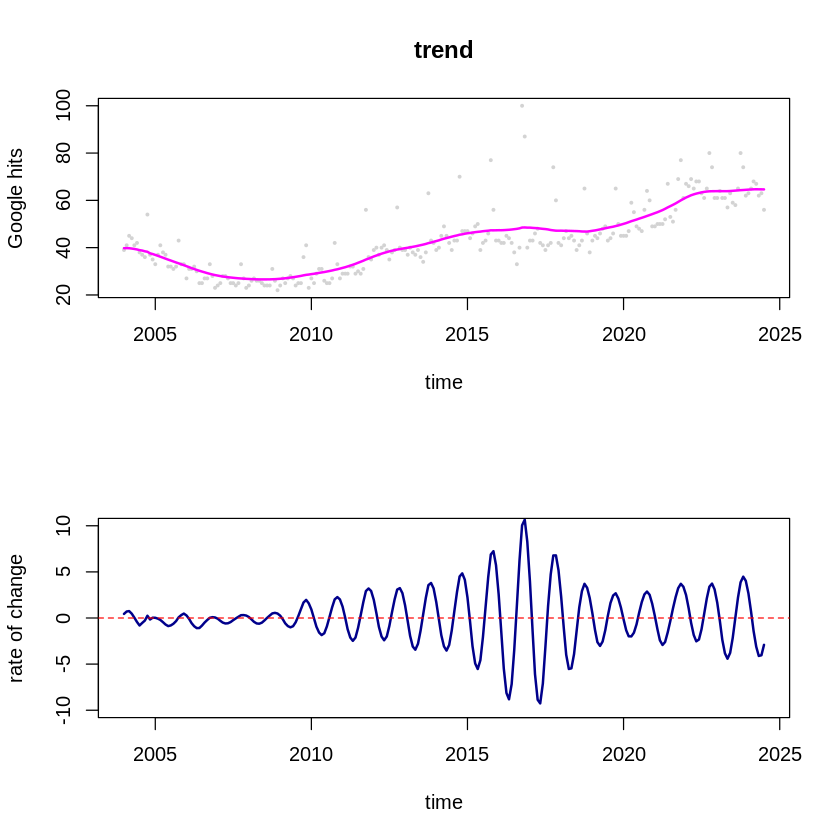

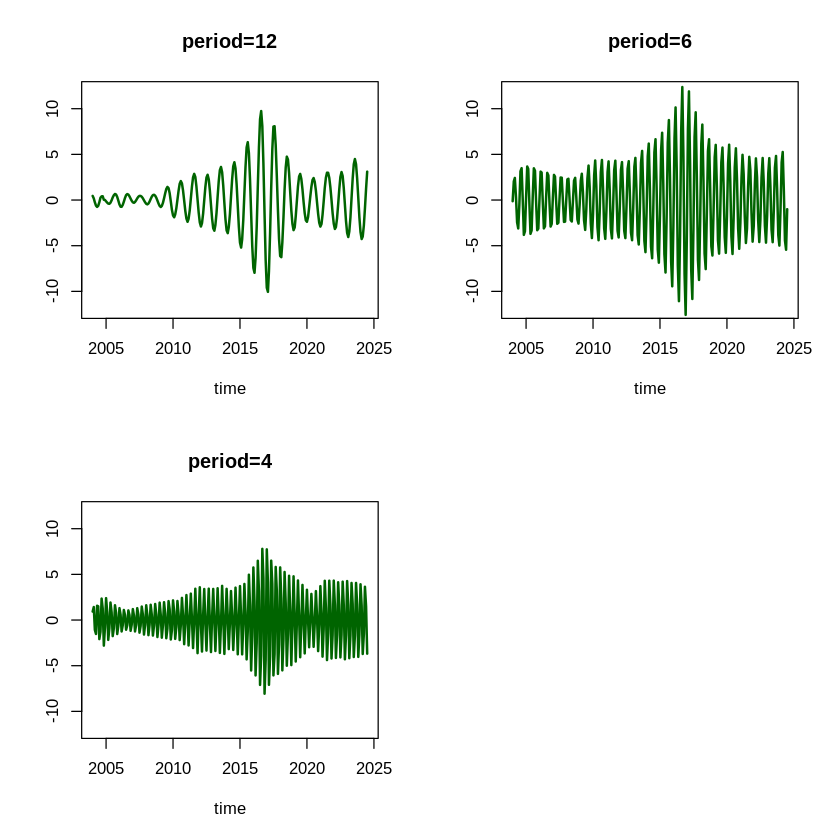

In [34]:
# download data
library(gtrendsR)
timeseries_data<-gtrends("time series", time="all")
plot(timeseries_data)
names(timeseries_data)

timeseries_data=timeseries_data$interest_over_time
data=list(yt=timeseries_data$hits)

library(dlm)
model_seasonal=dlmModTrig(s=12,q=3,dV=0,dW=1)
model_trend=dlmModPoly(order=1,dV=10,dW=rep(1,1),
m0=c(40))
model=model_trend+model_seasonal
model$C0=10*diag(7)
n0=1
S0=10
k=length(model$m0)
T=length(data$yt)

Ft=array(0,c(1,k,T))
Gt=array(0,c(k,k,T))
for(t in 1:T){
   Ft[,,t]=model$FF
   Gt[,,t]=model$GG
}

source('all_dlm_functions_unknown_v.R')
source('discountfactor_selection_functions.R')

matrices=set_up_dlm_matrices_unknown_v(Ft=Ft,Gt=Gt)
initial_states=set_up_initial_states_unknown_v(model$m0,
                                               model$C0,n0,S0)

df_range=seq(0.9,1,by=0.005)

## fit discount DLM
## MSE
results_MSE <- adaptive_dlm(data, matrices,
               initial_states, df_range,"MSE",forecast=FALSE)

## print selected discount factor
print(paste("The selected discount factor:",results_MSE$df_opt))

## retrieve filtered results
results_filtered <- results_MSE$results_filtered
ci_filtered <- get_credible_interval_unknown_v(
  results_filtered$ft,results_filtered$Qt,results_filtered$nt)

## retrieve smoothed results
results_smoothed <- results_MSE$results_smoothed
ci_smoothed <- get_credible_interval_unknown_v(
  results_smoothed$fnt, results_smoothed$Qnt,
  results_filtered$nt[length(results_smoothed$fnt)])

## plot smoothing results
par(mfrow=c(1,1))
index <- timeseries_data$date
plot(index, data$yt, ylab='Google hits',
     main = "Google Trends: time series", type = 'l',
     xlab = 'time', lty=3,ylim=c(0,100))
lines(index, results_smoothed$fnt, type = 'l', col='blue',
      lwd=2)
lines(index, ci_smoothed[, 1], type='l', col='blue', lty=2)
lines(index, ci_smoothed[, 2], type='l', col='blue', lty=2)

# Plot trend and rate of change
par(mfrow=c(2,1))
plot(index,data$yt,pch=19,cex=0.3,col='lightgray',xlab="time",
     ylab="Google hits",main="trend")
lines(index,results_smoothed$mnt[,1],lwd=2,col='magenta')
plot(index,results_smoothed$mnt[,2],col='darkblue',lwd=2,
     type='l', ylim=c(-10,10), xlab="time",
     ylab="rate of change")
abline(h=0,col='red',lty=2)

# Plot seasonal components
par(mfrow=c(2,2))
plot(index,results_smoothed$mnt[,3],lwd=2,col="darkgreen",
     type='l', xlab="time",ylab="",main="period=12",
     ylim=c(-12,12))
plot(index,results_smoothed$mnt[,5],lwd=2,col="darkgreen",
     type='l',xlab="time",ylab="",main="period=6",
     ylim=c(-12,12))
plot(index,results_smoothed$mnt[,7],lwd=2,col="darkgreen",
     type='l', xlab="time",ylab="",main="period=4",
     ylim=c(-12,12))

#Estimate for the observational variance: St[T]
results_filtered$St[T]